In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from dataset import VirtualStainDataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage.color import rgb2hed, hed2rgb
from unet import UNet
from torchsummary import summary
import torch
import numpy as np
import pandas as pd
from tiatoolbox.utils.misc import get_luminosity_tissue_mask
import seaborn as sns
from torchvision.io import read_image
from scipy import stats

In [31]:
# load dataset
dataset_dir = '/data/archief/AMC-data/Barrett/temp/patch_dataset_s0.25_512/'
dataset = VirtualStainDataset(dataset_dir)
print('Dataset contains: {} pairs.'.format(dataset.__len__()))
print(len(np.unique(dataset.he_files)))

Dataset contains: 16665 pairs.
16665


In [29]:
dataset_dir = '/data/archief/AMC-data/Barrett/temp/patch_dataset_s0.25_512'
he_files = [os.path.join(dataset_dir, 'HE', f) for f in os.listdir(os.path.join(dataset_dir, 'HE'))]
p53_files = [os.path.join(dataset_dir, 'p53', f) for f in os.listdir(os.path.join(dataset_dir, 'p53'))]

for he_file, p53_file in zip(he_files, p53_files):
    he = read_image(he_file)
    p53 = read_image(p53_file)
    print(he.dtype)
    break

torch.uint8


In [3]:
def DAB_density(ihc_rgb):
    """ Convert RGB colour space to Haematoxylin-Eosin-DAB (HED) colour
        space and calculate the percentage of DAB staining from the DAB channel.
        
    Args:
        ihc_rgb: p53 image patch (torch.Tensor) [C, H, W]
        
    Returns 
        dab_density: the percentage of DAB staining from the DAB channel (float)
        
    """
    ihc_hed = rgb2hed(ihc_rgb)
    dab_channel = ihc_hed[:, :, 2]
    # print('min: {}, max: {}'.format(np.min(dab_channel), np.max(dab_channel)))
    dab_density = np.mean(dab_channel)
    return dab_density

In [32]:
def DAB_density_norm(he_rgb, ihc_rgb):
    """ Convert RGB colour space to Haematoxylin-Eosin-DAB (HED) colour space and calculate the percentage of DAB staining from the DAB channel.
        Normalized by the amount of tissue in the patch, computed from the he.
        
    Args:
        he_rgb: he image patch (torch.Tensor) [C, H, W]
        ihc_rgb: p53 image patch (torch.Tensor) [C, H, W]
        
    Returns 
        dab_density: the percentage of DAB staining from the DAB channel (float)
        
    """
    # conver to hed and get the dab channel
    ihc_hed = rgb2hed(ihc_rgb)
    he_channel = ihc_hed[:, :, 0]
    dab_channel = ihc_hed[:, :, 2]
    
    # normalize by amount of tissue in the patch
    dab_density = np.sum(dab_channel) / np.sum(he_channel)
    
    return dab_density

In [33]:
def plot_hed_space(he_rgb, ihc_rgb):
    
    ihc_hed = rgb2hed(ihc_rgb)
    dab_density = DAB_density(ihc_rgb)
    dab_density_norm = DAB_density_norm(he_rgb, ihc_rgb)
    tissue_mask = get_luminosity_tissue_mask(he_rgb, threshold=0.85)
    
     # Create an RGB image for each of the stains
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))
    
    # Display
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
    ax = axes.ravel()
    
    ax[0].imshow(he_rgb)
    ax[0].set_title("HE")
    
    ax[1].imshow(ihc_rgb)
    ax[1].set_title("p53")
    
    # ax[2].imshow(tissue_mask)
    # ax[2].set_title("Tissue")

    ax[2].imshow(ihc_d)
    ax[2].set_title("DAB from p53\ndensity={:.4f}\ndensity norm: {:.4f}".format(dab_density, dab_density_norm))

    for a in ax.ravel():
        a.axis('off')

    fig.tight_layout()
    plt.show()

In [36]:
he_imgs = []
p53_imgs = []
dab_densities_norm = []

for i in range(1000):
    he, p53, dab = dataset.__getitem__(i)
    
    he_rgb = np.transpose(he.numpy(), (1, 2, 0)).astype(np.uint8)
    p53_rgb = np.transpose(p53.numpy(), (1, 2, 0)).astype(np.uint8)
           
    he_imgs.append(he_rgb)
    p53_imgs.append(p53_rgb)
    dab_densities_norm.append(float(dab.cpu().numpy()))
    
    # plot 
    # plot_hed_space(he_rgb, p53_rgb)

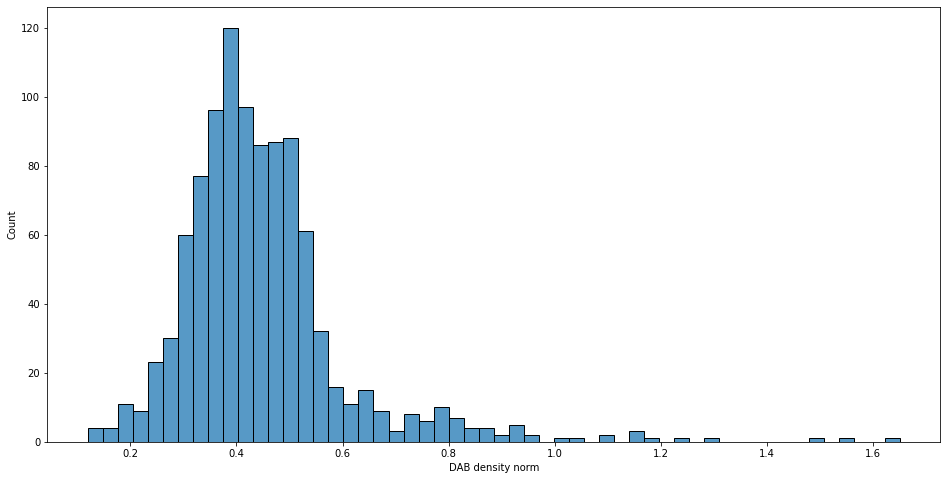

In [37]:
plt.figure(figsize=(16, 8))
sns.histplot(dab_densities_norm)
plt.xlabel('DAB density norm')
plt.show()

In [38]:
print(min(dab_densities_norm))
print(max(dab_densities_norm))

0.12010745704174042
1.6498010158538818


1.6498010158538818


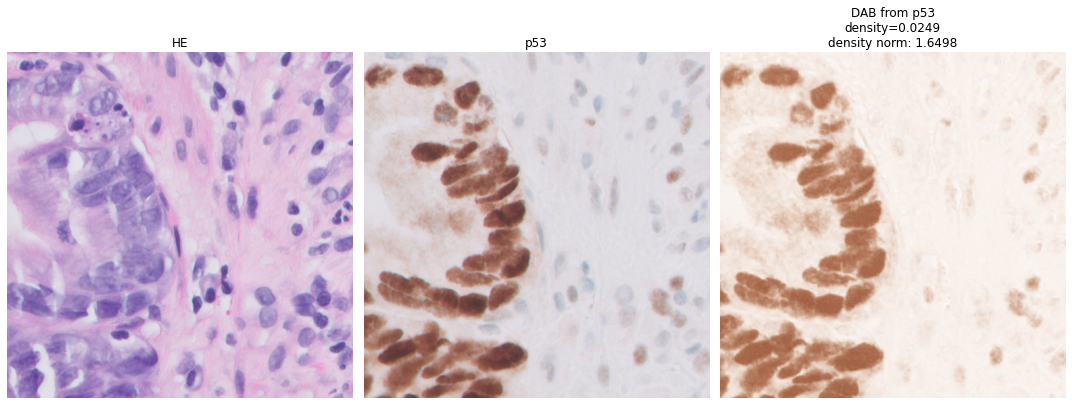

1.5599403381347656


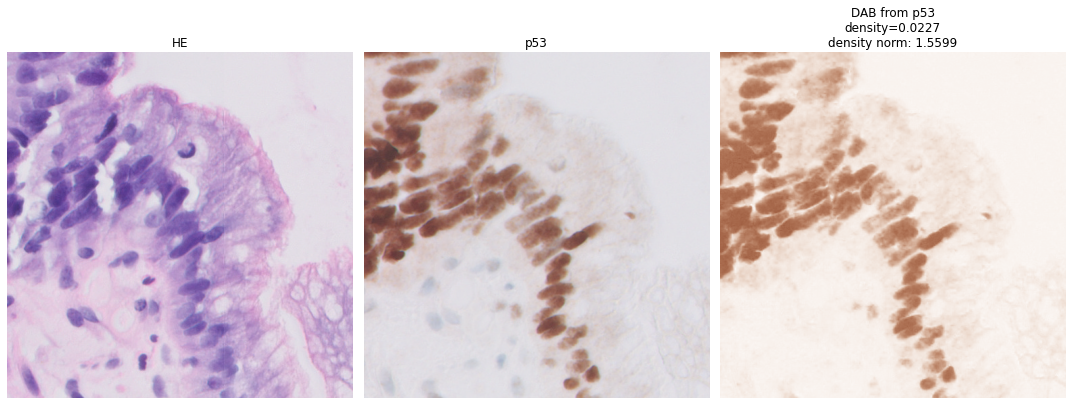

1.494739294052124


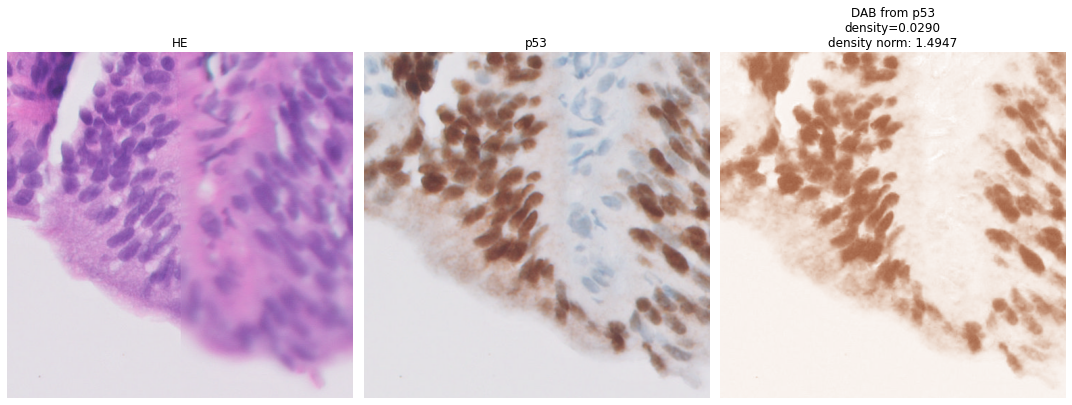

1.2939567565917969


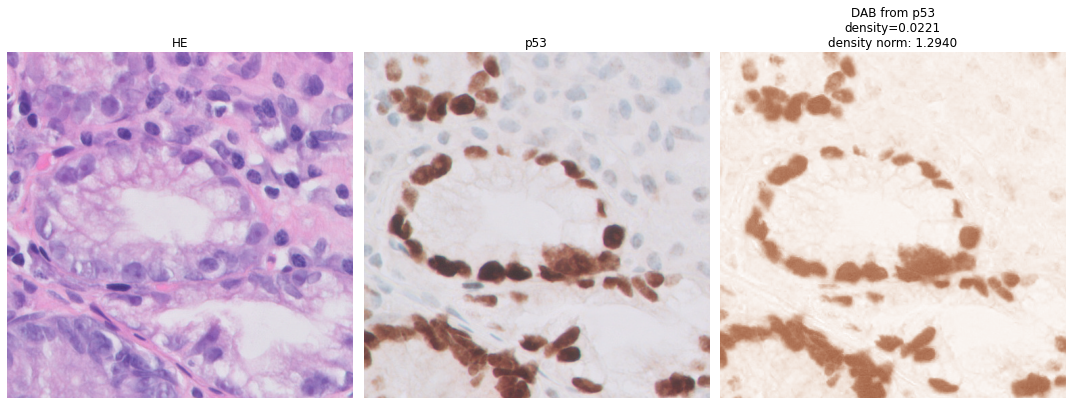

1.2264851331710815


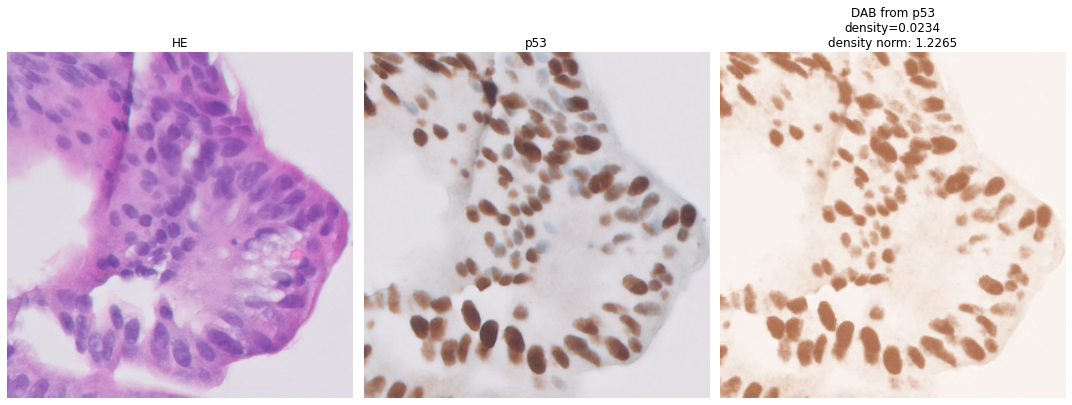

In [39]:
for i in np.argsort(dab_densities_norm)[::-1][:5]:
    print(dab_densities_norm[i])
    plot_hed_space(he_imgs[i], p53_imgs[i])

0.12010745704174042


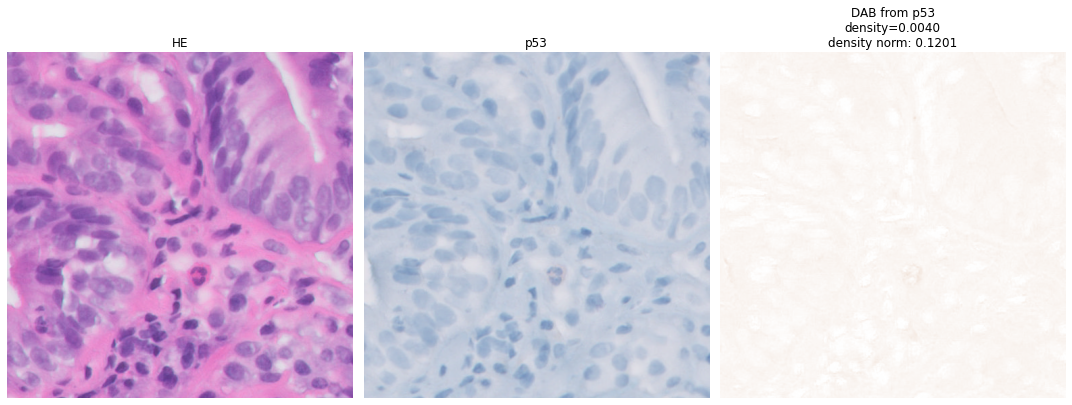

0.13968759775161743


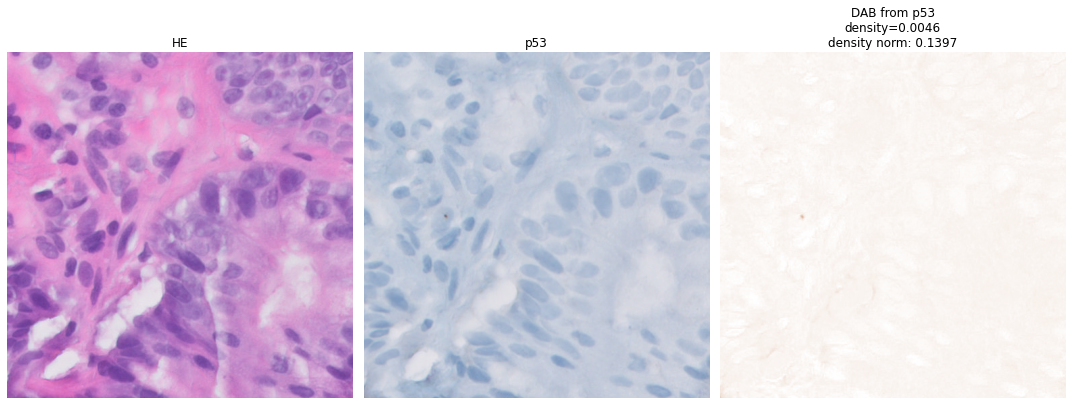

0.14228352904319763


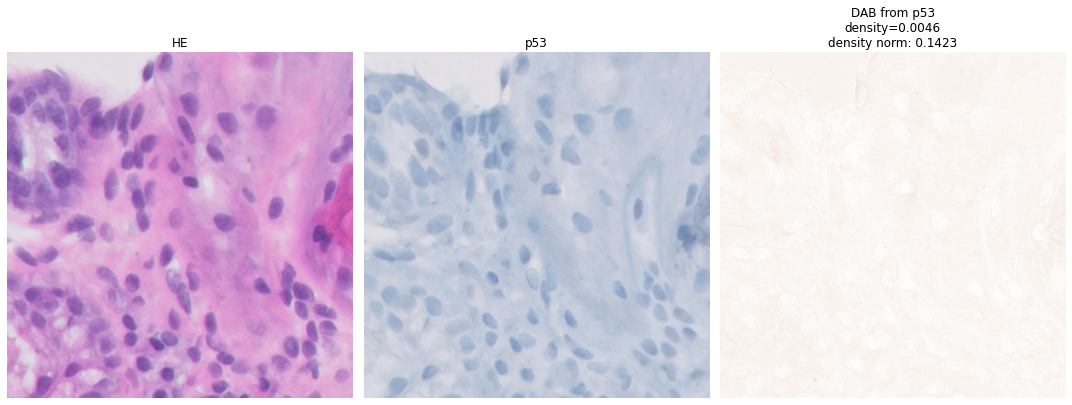

In [41]:
for i in np.argsort(dab_densities_norm)[:3]:
    print(dab_densities_norm[i])
    plot_hed_space(he_imgs[i], p53_imgs[i])